<a href="https://colab.research.google.com/github/vaishnav711/sopt/blob/main/RBS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install category_encoders xgboost

In [13]:
from google.colab import drive
import numpy as np
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import *
from matplotlib import pyplot
import xgboost as xgb

# Mount drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
fpath = r'/content/drive/MyDrive/RBS/temp.feather'
so_DF = pd.read_feather(fpath)

# Dataframe with lead_status == 'Open'
so_open_DF = so_DF.query("lead_status == 'Open'")

# Dataframe without lead_status as 'Open'
so_DF = so_DF.query("lead_status != 'Open'")

print(so_DF.shape)

(70777, 28)


In [ ]:
print('No. of nulls in the dataset: ', so_DF.isnull().values.sum())

print('\nNulls in individual columns:')
print(so_DF.isnull().sum())

In [ ]:
# skip
col_names = list(so_DF.columns)
col_list = []
for cn in col_names:
  count = so_DF[cn].count()
  nunique = so_DF[cn].nunique()
  data_type = so_DF[cn].dtype

  cntuple = (cn, count, nunique)
  col_list.append(cntuple)
  print(cntuple)

In [5]:
col_list = [('lead', 71138, 71138, True), ('do_not_modify_row_checksum', 71138, 71138, False), ('do_not_modify_modified_on', 0, 0, False), ('owner', 71138, 89, True),
 ('lead_source', 70302, 9, True), ('portfolio_id', 38369, 1744, False), ('created_on', 71138, 66250, False), ('lead_closed_date', 70777, 807, False),
 ('modified_on', 71138, 52484, False), ('rbs_bin', 51020, 44817, False), ('rbs_cin', 6642, 6492, False), ('merchant', 71113, 66278, False), ('trading_name', 1653, 1624, False),
 ('legal_entity_type', 64954, 10, True), ('current_provider', 24271, 26, True), ('mcc_code', 0, 0, False), ('lead_status', 71138, 3, True), ('status_reason', 71136, 30, True),
 ('lead_id', 0, 0, False), ('referral_id', 46537, 42687, False), ('currently_taking_payments', 31098, 3, True), ('ad_content', 6993, 140, True), ('campaign', 10470, 91, True),
 ('keyword', 3784, 320, True), ('landing_page', 10470, 16, True), ('medium', 10470, 26, True), ('source', 10468, 21, True), ('banked_customer', 60299, 3, True)]


col_selected = []
cn_selected = []
for cl in col_list:
  if cl[3] == True:
    col_selected.append(cl)
    cn_selected.append(cl[0])
print(col_selected)
 
so_DF = so_DF[cn_selected]

[('lead', 71138, 71138, True), ('owner', 71138, 89, True), ('lead_source', 70302, 9, True), ('legal_entity_type', 64954, 10, True), ('current_provider', 24271, 26, True), ('lead_status', 71138, 3, True), ('status_reason', 71136, 30, True), ('currently_taking_payments', 31098, 3, True), ('ad_content', 6993, 140, True), ('campaign', 10470, 91, True), ('keyword', 3784, 320, True), ('landing_page', 10470, 16, True), ('medium', 10470, 26, True), ('source', 10468, 21, True), ('banked_customer', 60299, 3, True)]


In [ ]:
#print(so_DF.shape)
#so_DF = so_DF.replace(to_replace='None', value=np.nan).dropna()
#so_DF = so_DF.dropna(axis=0, how='any')

so_DF = so_DF.replace(to_replace=np.nan, value='Unknown')
so_DF = so_DF.replace(to_replace='NULL', value='Unknown')
#print(so_DF.shape)

print('Columns after handling nulls')
print(so_DF.isnull().sum())

In [ ]:
cn_selected

In [ ]:
so_DF['lead_status'].value_counts()

Qualified       56832
Disqualified    13945
Name: lead_status, dtype: int64

In [ ]:
col_names = list(so_DF.columns)

for cn in col_names:
  count = so_DF[cn].count()
  nunique = so_DF[cn].nunique()
  data_type = so_DF[cn].dtype

  #if_cndt = (count > 0) and (count != nunique) and (data_type != 'datetime64[ns, UTC]')
  #if if_cndt:
  cntuple = (cn, count, nunique)
  print(cntuple)

('lead', 70777, 70777)
('owner', 70777, 87)
('lead_source', 70777, 10)
('legal_entity_type', 70777, 11)
('current_provider', 70777, 26)
('lead_status', 70777, 2)
('status_reason', 70777, 30)
('currently_taking_payments', 70777, 3)
('ad_content', 70777, 141)
('campaign', 70777, 92)
('keyword', 70777, 321)
('landing_page', 70777, 17)
('medium', 70777, 27)
('source', 70777, 22)
('banked_customer', 70777, 3)


In [7]:
# Label Encoding y variable
le = LabelEncoder()
so_DF['lead_status_N'] = le.fit_transform(so_DF['lead_status'].values)

X_var = ['owner', 'lead_source', 'legal_entity_type', 'current_provider', 'status_reason', 'currently_taking_payments', 'ad_content', 'campaign', 'keyword', 'landing_page', 'medium', 'source', 'banked_customer']
y_var = ['lead_status_N']
X = so_DF[X_var]
y = so_DF[y_var]

# Binary Encoding X variables
ce_be = ce.BinaryEncoder(cols = X_var)
X = ce_be.fit_transform(X, y['lead_status_N'])

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, stratify=y, random_state=123)

print(train_X.shape, test_X.shape)
print()
print(f'Number of rows in Train dataset: {train_X.shape[0]}')
print(train_y['lead_status_N'].value_counts())
print()
print(f'Number of rows in Test dataset: {test_X.shape[0]}')
print(test_y['lead_status_N'].value_counts())

(49543, 70) (21234, 70)

Number of rows in Train dataset: 49543
1    39782
0     9761
Name: lead_status_N, dtype: int64

Number of rows in Test dataset: 21234
1    17050
0     4184
Name: lead_status_N, dtype: int64


In [8]:
%%time

model = xgb.XGBClassifier(max_depth=4,
                        subsample=0.9,
                        objective='binary:logistic',
                        n_estimators=200,
                        learning_rate = 0.1)
eval_set = [(train_X, train_y), (test_X, test_y)]
model.fit(train_X, train_y.values.ravel(), early_stopping_rounds=10, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-error:0.00327	validation_0-logloss:0.599625	validation_1-error:0.00405	validation_1-logloss:0.59958
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.00327	validation_0-logloss:0.522081	validation_1-error:0.00405	validation_1-logloss:0.522292
[2]	validation_0-error:0.001756	validation_0-logloss:0.457643	validation_1-error:0.002308	validation_1-logloss:0.457759
[3]	validation_0-error:0.001756	validation_0-logloss:0.40276	validation_1-error:0.002308	validation_1-logloss:0.403218
[4]	validation_0-error:0.001756	validation_0-logloss:0.356394	validation_1-error:0.002308	validation_1-logloss:0.356521
[5]	validation_0-error:0	validation_0-logloss:0.31642	validation_1-error:0	validation_1-logloss:0.31657
[6]	validation_0-error:0.001756	validation_0-logloss:0.281493	validation_1-error:0.002308	validation_1-logloss:0.2818
[7]	validation_0-er

In [9]:
# make predictions for test data
y_pred = model.predict(test_X)
predictions = [round(value) for value in y_pred]

In [10]:
# evaluate predictions
accuracy = accuracy_score(test_y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 100.00%


In [11]:
confusion_matrix(predictions, test_y)

array([[ 4184,     0],
       [    0, 17050]])

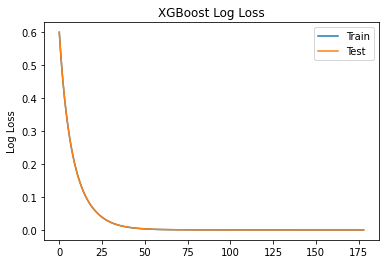

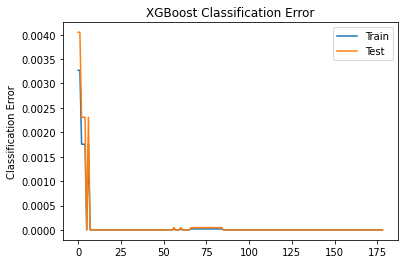

In [14]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()


In [ ]:
def trim_str_cols(df):
  # Removing whitespaces
  df_trimmed = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
  return df_trimmed

def dropping_duplicates(df):
  # Dropping duplicate rows in dataframe
  df_wd = df.drop_duplicates()
  return df_wd

cols_to_rename = {'test':'TEST', 'odi':'ODI', 't20':'T20'}

def rename_cols(df, cols_to_rename):
  # Renaming columns in dataframe
  df = df.rename(columns=cols_to_rename)
  return df

